In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wmfdata as wmf

from wmfdata.utils import (
    pct_str,
    pd_display_all
)

In [3]:
wmf.charting.set_mpl_style()

The experiment was released to the KaiOS store on 8 April, in version 1.6.0 of the app. On 5 May, we [fixed](https://www.mediawiki.org/w/index.php?title=Wikipedia_for_KaiOS/engagement1&diff=4563366&oldid=4520262) a vandalization of our config that prevent the recommendations from being shown.

There was a significant break in the trending articles job, from 6 October through 20 October (the trending articles from 5 October continued to be displayed during this period).

## Data storage

Log of updates:
* 2021-07-29: stored data for \[2021-05-06, 2021-07-27\] in `neilpquinn.kaios_experiment_event`
* 2021-09-07: stored data for \[2021-07-28, 2021-09-05\] in `neilpquinn.kaios_experiment_event`
* 2021-10-21: stored data for \[2021-07-23, 2021-10-20\] in `nshahquinn.kaios_experiment_event` (with extra columns `dt` and `wiki`).
* 2021-11-05: stored data for \[2021-10-21, 2021-11-04\] in `nshahquinn.kaios_experiment_event`

In [4]:
SPARK_PARTITION_DATE = (
    "CONCAT("
        "CAST(year AS STRING), '-', "
        "LPAD(CAST(month AS STRING), 2, '0'), '-', "
        "LPAD(CAST(day AS STRING), 2, '0')"
    ")"
)

# Both start and end dates are included
START_DATE = "2021-10-21"
END_DATE = "2021-11-04"

In [ ]:
wmf.spark.run("""
CREATE TABLE nshahquinn.kaios_experiment_event (
    dt STRING,
    client_dt STRING,
    server_dt STRING,
    pageview_id STRING,
    session_id STRING,
    user_id STRING,
    load_dt STRING,
    page_open_time BIGINT,
    page_visible_time BIGINT,
    section_count BIGINT,
    opened_section_count BIGINT,
    is_main_page BOOLEAN,
    page_namespace BIGINT,
    wiki STRING,
    experiment_group STRING,
    country STRING,
    country_subdivision STRING,
    app_version STRING
) STORED AS PARQUET
""")

In [ ]:
wmf.spark.run(f"""
INSERT INTO TABLE nshahquinn.kaios_experiment_event
SELECT
    dt,
    client_dt,
    meta.dt AS server_dt,
    event.pageview_token AS pageview_id,
    event.session_id AS session_id,
    event.user_id AS user_id,
    event.load_dt AS load_dt,
    event.page_open_time AS page_open_time,
    event.page_visible_time AS page_visible_time,
    event.section_count AS section_count,
    event.opened_section_count AS opened_section_count,
    event.is_main_page AS is_main_page,
    event.page_namespace AS page_namespace,
    wiki,
    event.tests[0].`group` AS experiment_group,
    geocoded_data["country_code"] AS country,
    geocoded_data["subdivision"] AS country_subdivision,
    event.app_version AS app_version
FROM event.inukapageview
WHERE
    {SPARK_PARTITION_DATE} BETWEEN '{START_DATE}' AND '{END_DATE}'
    AND SIZE(event.tests) > 0
    AND event.is_production
""")

The drop in events starting on 29 August is expected, since that's when KaiOS stopped running ads for our app in their ad network.

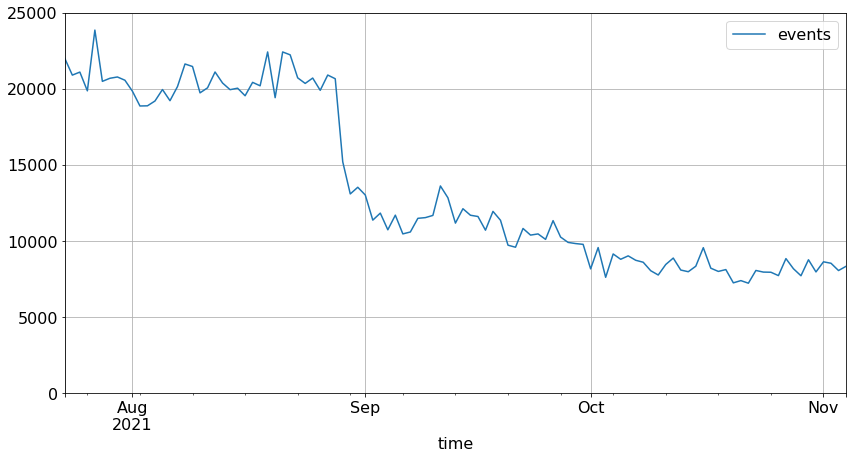

In [16]:
(
    wmf.presto.run("""
        SELECT
            DATE(FROM_ISO8601_TIMESTAMP(dt)) AS time,
            COUNT(*) AS events
        FROM nshahquinn.kaios_experiment_event
        GROUP BY
            DATE(FROM_ISO8601_TIMESTAMP(dt))
        ORDER BY time
    """).set_index("time")
    .plot(ylim=(0, 25000))
);

In [18]:
type(_8.iloc[4, 0])

str

In [18]:
wmf.presto.run("""
SELECT
    COUNT(*) AS events,
    COUNT(DISTINCT user_id) AS users
FROM neilpquinn.kaios_experiment_event
WHERE country NOT IN ('NG', 'PK', 'TZ', 'UG')
""")

,events,users
0,1320421,39211


In [17]:
wmf.presto.run("""
SELECT
    COUNT(*) AS events,
    COUNT(DISTINCT user_id) AS users
FROM neilpquinn.kaios_experiment_event
WHERE country IN ('NG', 'PK', 'TZ', 'UG')
""")

,events,users
0,1995635,99341


<div class="alert alert-box alert-warning">
NOTE: Code below this point has not been updated to pull from the new storage table.
</div>

In [ ]:
wmf.presto.run(f"""
SELECT
    event.pageview_token AS pageview_id,
    event.session_id AS session_id,
    event.user_id AS user_id,
    MIN(FROM_ISO8601_TIMESTAMP(meta.dt)) AS start_time,
    MAX(
        -- Convert milliseconds to minutes
        CAST(event.page_visible_time AS REAL) / 1000 / 60
    ) AS page_viewing_min,
    -- If any users shift groups or countries, the aggregation
    -- results in an concatenated string, so those users can be identified and excluded
    ARRAY_JOIN(SET_AGG(geocoded_data['country_code']), '-') AS country,
    REDUCE(
        SET_UNION(event.tests), 
        NULL, 
        (i, x) -> IF(
            x.name = '2021-KaiOS-app-homepage-content-suggestions', 
            IF(i IS NULL, x."group", CONCAT(i, '-', x."group")),
            i
        ),
        x -> x
    ) AS experiment_group
FROM event.inukapageview
WHERE
    {PRESTO_PARTITION_DATE} >= '2021-05-06'
    AND geocoded_data['country_code'] IN ('NG', 'PK', 'TZ', 'UG')
    AND event.app_version >= '1.6.0'
    AND event.is_production
GROUP BY
    event.pageview_token,
    event.session_id,
    event.user_id
""")

In [ ]:
user = wmf.presto.run(f"""
WITH pageview AS (

), session AS (
    SELECT
        session_id,
        user_id,
        MIN(start_time) AS start_time,
        SUM(page_viewing_min) AS page_viewing_min,
        ARRAY_JOIN(SET_AGG(country), '-') AS country,
        ARRAY_JOIN(SET_AGG(experiment_group), '-') AS experiment_group
    FROM pageview
    GROUP BY
        user_id,
        session_id
)
SELECT
    user_id,
    MIN(start_time) AS experiment_entry,
    CAST(DATE_DIFF('second', MIN(start_time), CURRENT_TIMESTAMP) AS REAL) / 60 / 60 / 24  AS days_in_experiment,
    COUNT(1) AS sessions,
    AVG(page_viewing_min) AS mean_session_min,
    ARRAY_JOIN(SET_AGG(country), '-') AS country,
    ARRAY_JOIN(SET_AGG(experiment_group), '-') AS experiment_group
FROM session
GROUP BY user_id
""").assign(
    experiment_entry=lambda df: pd.to_datetime(df["experiment_entry"]),
    country=lambda df: df["country"].astype("category"),
    experiment_group=lambda df: df["experiment_group"].astype("category")
)

In [ ]:
user.info()

# Data exploration

## Countries and experiment groups

In [ ]:
pd.pivot_table(
    user, 
    values="sessions",
    index="country",
    columns="experiment_group",
    aggfunc=len,
    margins=True
)

In [ ]:
user = user.query("experiment_group != 'control-trending-articles'")

In [ ]:
pd.pivot_table(
    user, 
    values="sessions",
    index="country",
    columns="experiment_group",
    aggfunc=len,
    margins=True
)

## Session duration

In [ ]:
user["mean_session_min"].describe()

In [ ]:
with pd.option_context("display.min_rows", 20):
    display(user["mean_session_min"].sort_values(ascending=False))

Some users have pathological session lengths. Let's remove them.

In [ ]:
user = user.query("mean_session_min >= 0 and mean_session_min < 600")

In [ ]:
user["mean_session_min"].describe()

In [ ]:
# Proportion of users with mean session length of 10 minutes or more
print(pct_str(user["mean_session_min"][lambda x: x >= 10].pipe(len) / len(session)))

In [ ]:
user["mean_session_min"][lambda x: x < 10].plot(kind='hist', bins=100);

In [ ]:
control_session_lengths = user.query("experiment_group == 'control'")["mean_session_min"][lambda x: x <= 10]
trending_articles_session_lengths = user.query("experiment_group == 'trending-articles'")["mean_session_min"][lambda x: x <= 10]

plt.hist([control_session_lengths, trending_articles_session_lengths], bins=20, label=["control", "trending_articles"])
plt.legend();

## Session count

In [ ]:
user["sessions"].describe()

In [ ]:
# Proportion of users with ten sessions or more
print(pct_str(user["sessions"][lambda x: x >= 10].pipe(len) / len(user)))

In [ ]:
control_session_counts = user.query("experiment_group == 'control'")["sessions"][lambda x: x <= 10]
trending_articles_session_counts = user.query("experiment_group == 'trending-articles'")["sessions"][lambda x: x <= 10]

plt.hist([control_session_counts, trending_articles_session_counts], bins=9, label=["control", "trending_articles"])
plt.legend();

In [ ]:
user["experiment_entry"].describe(datetime_is_numeric=True)

In [ ]:
user["days_in_experiment"].describe()

## Correlations

In [ ]:
pd.plotting.scatter_matrix(
    user[["sessions", "mean_session_min", "days_in_experiment"]],
    diagonal="kde",
    figsize=(18, 12)
);

In [ ]:
user.corr()

In [ ]:
# We should actually save this as a timestamped file, so we can cleanly replicate the analysis
user.to_parquet('data/2021-06-24_experiment_user.parquet')